## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70586,00017406_000.png,No Finding,0,17406,63,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_008/images/00017406_000.png
110264,00030026_004.png,No Finding,4,30026,58,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030026_004.png
57338,00014223_021.png,Atelectasis|Infiltration,21,14223,27,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_007/images/00014223_021.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda label: label.split('|')).tolist())))
print('Labels ({}): {}'.format(len(labels), labels))

for label in labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)
all_xray_df.sample(10)

Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
67344,00016627_000.png,Mass,0,16627,46,F,PA,2686,2673,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22514,00005966_002.png,Infiltration,2,5966,51,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88807,00022021_002.png,Infiltration|Pneumonia,2,22021,57,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
17879,00004816_000.png,No Finding,0,4816,73,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82922,00020393_002.png,Nodule,2,20393,42,M,AP,2884,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87074,00021489_002.png,No Finding,2,21489,35,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107767,00029130_000.png,Infiltration,0,29130,34,F,PA,1748,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31462,00008229_003.png,No Finding,3,8229,48,F,PA,2622,2777,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17856,00004808_095.png,No Finding,95,4808,38,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
81942,00020158_022.png,Cardiomegaly|Edema|Effusion|Infiltration|Nodule,22,20158,50,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda pn: '1' if pn > 0 else '0')
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
26102,00006851_012.png,Atelectasis,12,6851,41,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
103710,00027685_007.png,Infiltration,7,27685,61,F,PA,2804,2445,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
99166,00026222_007.png,No Finding,7,26222,52,M,PA,2890,2782,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
75539,00018539_005.png,Infiltration,5,18539,34,F,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
86775,00021403_002.png,Nodule,2,21403,24,F,AP,2684,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
23632,00006255_007.png,No Finding,7,6255,46,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
29344,00007632_009.png,No Finding,9,7632,45,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
57201,00014201_005.png,Atelectasis|Infiltration,5,14201,29,F,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
87292,00021554_000.png,No Finding,0,21554,52,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
107235,00028939_000.png,No Finding,0,28939,29,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [5]:
print(f"Pneumonia cases in data: {len(all_xray_df[all_xray_df.pneumonia_class == '1'])/len(all_xray_df)*100}%")

Pneumonia cases in data: 1.2763110952550838%


## Create your training and testing data:

In [6]:
def create_splits():
    train_data, val_data = train_test_split(all_xray_df,
                                            test_size = 0.2,
                                            stratify = all_xray_df['pneumonia_class'])
    
    # balance positive to negative training samples to 50:50
    p_inds = train_data[train_data.pneumonia_class == '1'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class == '0'].index.tolist()
    np_sample = sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    
    # improve extremely skewed validation samples to 1:5
    p_inds = val_data[val_data.pneumonia_class == '1'].index.tolist()
    np_inds = val_data[val_data.pneumonia_class == '0'].index.tolist()
    np_sample = sample(np_inds, len(p_inds)*5)
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

train_data, val_data = create_splits()
print(f"Pneumonia cases in training data: {len(train_data[train_data.pneumonia_class == '1'])/len(train_data)*100}%")
print(f"Pneumonia cases in validation data: {len(val_data[val_data.pneumonia_class == '1'])/len(val_data)*100}%")

Pneumonia cases in training data: 50.0%
Pneumonia cases in validation data: 16.666666666666664%


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
IMG_SIZE = (224, 224)
def my_image_augmentation():
    return ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 5, 
                              shear_range = 0.1,
                              zoom_range = 0.05
                        )

def no_image_augmentation():
    return ImageDataGenerator(rescale=1./255.0)

def make_train_gen():
    return my_image_augmentation().flow_from_dataframe(dataframe = train_data, 
                                         directory = None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 128)


def make_val_gen():
    return no_image_augmentation().flow_from_dataframe(dataframe = val_data, 
                                             directory = None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 1500)


train_gen = make_train_gen()
val_gen = make_val_gen()

Found 2290 validated image filenames belonging to 2 classes.
Found 1716 validated image filenames belonging to 2 classes.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

print("Occurance of pneumonia classes in val data", np.unique(valY, return_counts = True))

Occurance of pneumonia classes in val data (array([0., 1.], dtype=float32), array([1246,  254]))


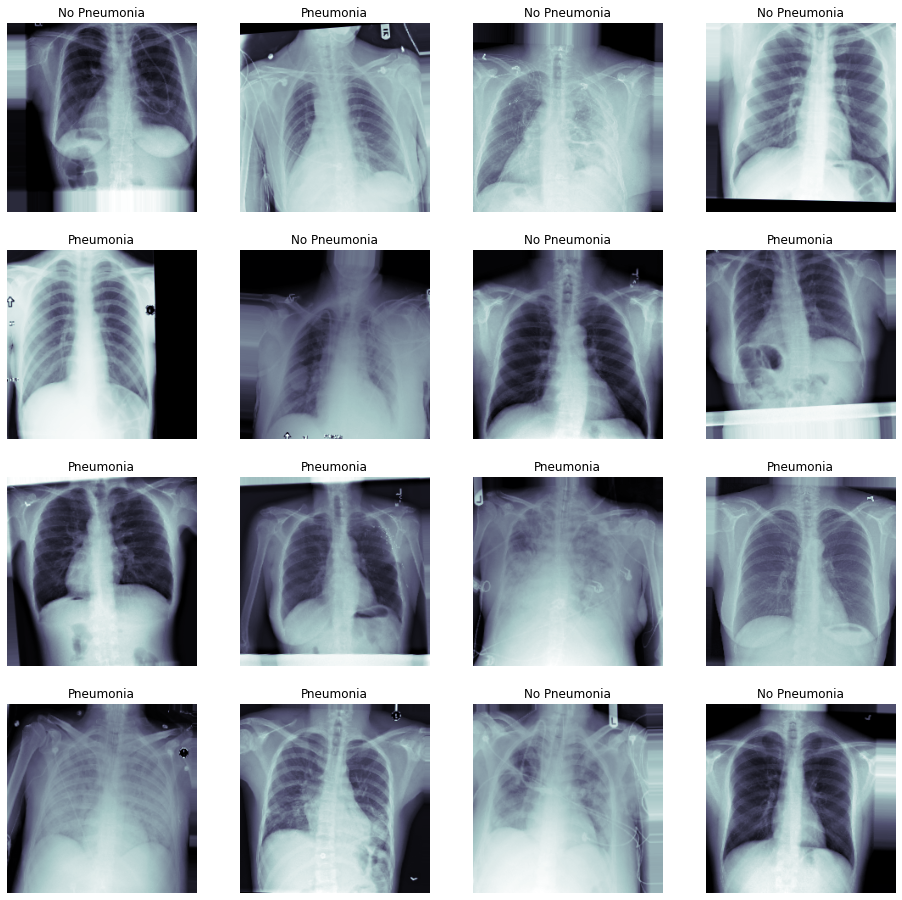

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

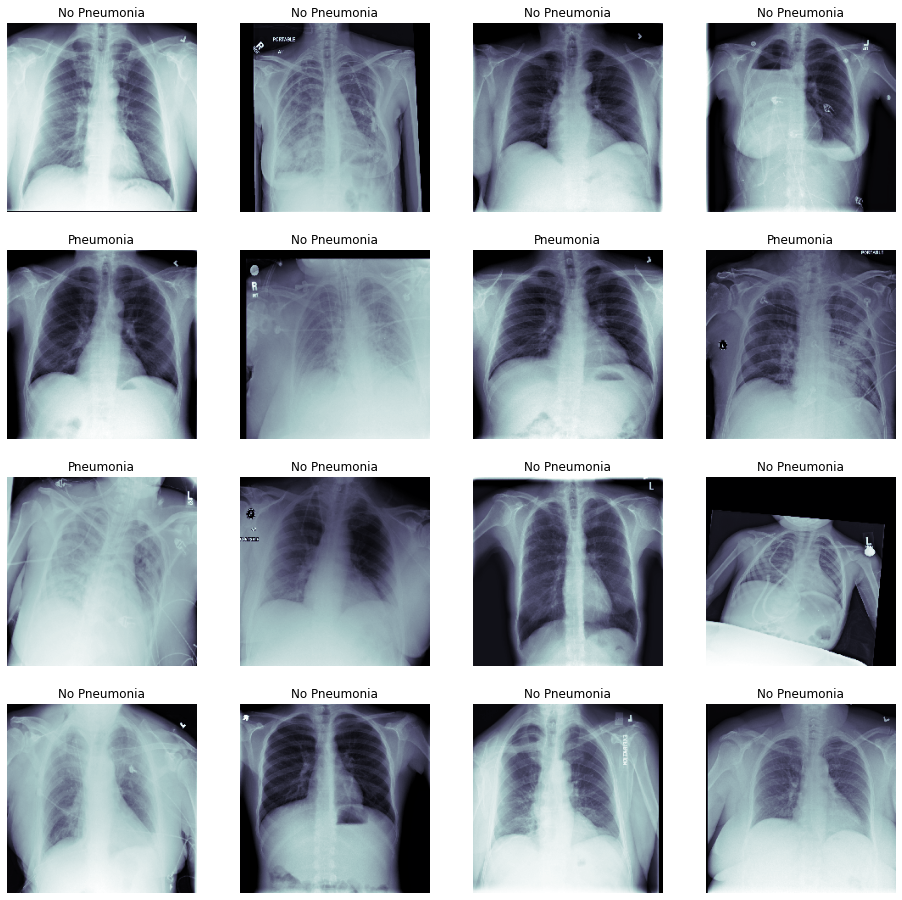

In [10]:
## Look at some examples of our validation data.

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(valX, valY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model():
    
    model = DenseNet121(include_top=True, weights='imagenet')
    
    print(f"Layers in model: {len(model.layers)}")
    transfer_layer = model.get_layer('avg_pool')
    base_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # freezing all but the last 2 DenseNet layers
    for layer in base_model.layers[0:411]:
        layer.trainable = False
        
    print('Layers:')
    for layer in base_model.layers:
        print('\t', layer.name, layer.trainable)
    
    return base_model

base_model = load_pretrained_model()

33193984/33188688 [==============================] - 1s 0us/step
Layers in model: 429
Layers:
	 input_1 False
	 zero_padding2d_1 False
	 conv1/conv False
	 conv1/bn False
	 conv1/relu False
	 zero_padding2d_2 False
	 pool1 False
	 conv2_block1_0_bn False
	 conv2_block1_0_relu False
	 conv2_block1_1_conv False
	 conv2_block1_1_bn False
	 conv2_block1_1_relu False
	 conv2_block1_2_conv False
	 conv2_block1_concat False
	 conv2_block2_0_bn False
	 conv2_block2_0_relu False
	 conv2_block2_1_conv False
	 conv2_block2_1_bn False
	 conv2_block2_1_relu False
	 conv2_block2_2_conv False
	 conv2_block2_concat False
	 conv2_block3_0_bn False
	 conv2_block3_0_relu False
	 conv2_block3_1_conv False
	 conv2_block3_1_bn False
	 conv2_block3_1_relu False
	 conv2_block3_2_conv False
	 conv2_block3_concat False
	 conv2_block4_0_bn False
	 conv2_block4_0_relu False
	 conv2_block4_1_conv False
	 conv2_block4_1_bn False
	 conv2_block4_1_relu False
	 conv2_block4_2_conv False
	 conv2_block4_concat False
	 c

In [12]:
def build_my_model():
    
    model = Sequential()
    model.add(base_model)
#     model.add(Flatten()) # flatten conv layer
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=0.001)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


my_model = build_my_model()

print(my_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1024)              7037504   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 331,073
Non-trainable params: 6,707,456
_________________________________________________________________
None


In [13]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training
weight_path="{}_my_model.dropout.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = 'binary_accuracy', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor = 'binary_accuracy', 
                      mode = 'max', 
                      patience = 10)

reduce_lr = ReduceLROnPlateau(monitor = 'binary_accuracy', 
                              factor = 0.1,
                              patience = 5,
                              min_lr = 1e-5,
                              verbose = 1)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [14]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
18/18 [==============================] - 91s 5s/step - loss: 0.7264 - binary_accuracy: 0.5830 - val_loss: 0.5761 - val_binary_accuracy: 0.7160

Epoch 00001: binary_accuracy improved from -inf to 0.58297, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 2/100
18/18 [==============================] - 52s 3s/step - loss: 0.6699 - binary_accuracy: 0.6362 - val_loss: 0.4675 - val_binary_accuracy: 0.8120

Epoch 00002: binary_accuracy improved from 0.58297 to 0.63624, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 3/100
18/18 [==============================] - 59s 3s/step - loss: 0.6634 - binary_accuracy: 0.6419 - val_loss: 0.7677 - val_binary_accuracy: 0.4987

Epoch 00003: binary_accuracy improved from 0.63624 to 0.64192, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 4/100
18/18 [==============================] - 59s 3s/step - loss: 0.6247 - binary_accuracy: 0.6703 - val_loss: 1.2880 - val_binary_accuracy: 0.2240

Epoch 00004: 


Epoch 00031: binary_accuracy improved from 0.91354 to 0.91747, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 32/100
18/18 [==============================] - 59s 3s/step - loss: 0.2096 - binary_accuracy: 0.9188 - val_loss: 1.2268 - val_binary_accuracy: 0.8027

Epoch 00032: binary_accuracy improved from 0.91747 to 0.91878, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 33/100
18/18 [==============================] - 59s 3s/step - loss: 0.1984 - binary_accuracy: 0.9166 - val_loss: 2.0508 - val_binary_accuracy: 0.5193

Epoch 00033: binary_accuracy did not improve from 0.91878
Epoch 34/100
18/18 [==============================] - 59s 3s/step - loss: 0.1937 - binary_accuracy: 0.9183 - val_loss: 3.4772 - val_binary_accuracy: 0.2867

Epoch 00034: binary_accuracy did not improve from 0.91878
Epoch 35/100
18/18 [==============================] - 59s 3s/step - loss: 0.1843 - binary_accuracy: 0.9271 - val_loss: 4.0708 - val_binary_accuracy: 0.3467

Epoch 00035

18/18 [==============================] - 59s 3s/step - loss: 0.0850 - binary_accuracy: 0.9716 - val_loss: 3.7032 - val_binary_accuracy: 0.4387

Epoch 00066: binary_accuracy improved from 0.96856 to 0.97162, saving model to pneumonia_class_my_model.dropout.best.hdf5
Epoch 67/100
18/18 [==============================] - 59s 3s/step - loss: 0.0917 - binary_accuracy: 0.9690 - val_loss: 3.6988 - val_binary_accuracy: 0.4387

Epoch 00067: binary_accuracy did not improve from 0.97162
Epoch 68/100
18/18 [==============================] - 59s 3s/step - loss: 0.1078 - binary_accuracy: 0.9611 - val_loss: 3.7028 - val_binary_accuracy: 0.4393

Epoch 00068: binary_accuracy did not improve from 0.97162
Epoch 69/100
18/18 [==============================] - 60s 3s/step - loss: 0.1021 - binary_accuracy: 0.9629 - val_loss: 3.6917 - val_binary_accuracy: 0.4407

Epoch 00069: binary_accuracy did not improve from 0.97162
Epoch 70/100
18/18 [==============================] - 60s 3s/step - loss: 0.0924 - binary

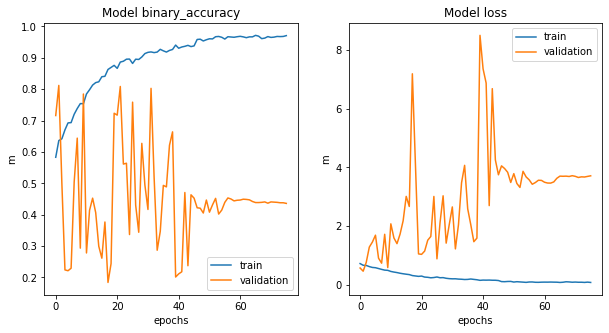

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

metric = ['binary_accuracy', 'loss']
for i, m in enumerate(metric):
  ax[i].plot(history.history[m])
  ax[i].plot(history.history['val_'+ m])
  ax[i].set_title('Model {}'.format(m))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel('m')
  ax[i].legend(['train', 'validation'])

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1500/1500 [==============================] - 25s 17ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [18]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [20]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [21]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)